## 📕 Importing Libraries and Dataset ##

I'm looking for tips on how I can improve my CNN creation. This work achieved accuracy of 78% but it is clear to me that there is some overfitting here. Feel free to add a comment that might help me in my journey. Thank you!

In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

# Keras - tensorflow
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
import tensorflow.keras.models

In [2]:
train_loc = 'Fold1/Fold1/Train'
val_loc = 'Fold1/Fold1/Val'
test_loc = 'Fold1/Fold1/Test'

In [3]:
train = ImageDataGenerator(rescale = 1/255)
validation = ImageDataGenerator(rescale = 1/255)
test = ImageDataGenerator(rescale = 1/255)

In [4]:
"""
https://stackoverflow.com/questions/59439128/what-does-class-mode-parameter-in-keras-image-gen-flow-from-directory-signify

class_mode: One of "categorical", "binary", "sparse", "input", or None. 
Default: "categorical". Determines the type of label arrays that are returned: - "categorical" will be 
2D one-hot encoded labels, - "binary" will be 1D binary labels, "sparse" will be 1D integer labels,
 - "input" will be images identical to input images (mainly used to work with autoencoders).
  - If None, no labels are returned (the generator will only yield batches of image data, 
  which is useful to use with model.predict_generator()). 
  Please note that in case of class_mode None, the data still needs to reside in a subdirectory 
  of directory for it to work correctly.

"""

train_dataset = train.flow_from_directory(directory=train_loc,
                                      target_size=(224,224),
                                      class_mode = "binary",
                                      batch_size=32,
                                      shuffle=True,
                                      seed=42)

validation_dataset = validation.flow_from_directory(directory=val_loc,
                                           target_size=(224,224),
                                           class_mode = "binary",
                                           batch_size=32,
                                           shuffle=True,
                                           seed=42)

test_dataset = test.flow_from_directory(directory=test_loc,
                                     target_size=(224,224),
                                     class_mode = "binary",
                                     batch_size=32,
                                     shuffle=False,
                                     seed = 42)

Found 2142 images belonging to 2 classes.
Found 420 images belonging to 2 classes.
Found 45 images belonging to 2 classes.


In [8]:
print('*' * 80)
print(f'Training Classes and shape: ',train_dataset.class_indices, train_dataset.image_shape)
print(f'Validation Clases and shape: ',validation_dataset.class_indices, validation_dataset.image_shape )
print(f'Test Classes and shape: ',test_dataset.class_indices, test_dataset.image_shape)
print('*' * 80)

********************************************************************************
Training Classes and shape:  {'Monkeypox': 0, 'Others': 1} (224, 224, 3)
Validation Clases and shape:  {'Monkeypox': 0, 'Others': 1} (224, 224, 3)
Test Classes and shape:  {'Monkeypox': 0, 'Others': 1} (224, 224, 3)
********************************************************************************


## 🤖 CNN ##

In [9]:
def plot_history(history):
    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="val accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="val error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [10]:
data_augmentation = keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal",
                                                                                  input_shape= (224,224,3)),
                                      layers.experimental.preprocessing.RandomZoom(0.1),
                                      layers.experimental.preprocessing.RandomRotation(0.1),                 
])


2022-12-03 11:59:50.860122: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
model = tf.keras.models.Sequential([#data_augmentation,
                                    tf.keras.layers.Conv2D(32,(3,3), activation='relu', input_shape = (224,224,3)), ### 1st conv layer
                                    tf.keras.layers.MaxPool2D((2,2), strides=(2, 2)),
                                    #tf.keras.layers.Dropout(0.2),
                                    #tf.keras.layers.BatchNormalization(),

                                    ## 2nd conv layer
                                    tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
                                    tf.keras.layers.MaxPool2D((2,2), strides=(2, 2)),
                                    #tf.keras.layers.Dropout(0.1),
                                    #tf.keras.layers.BatchNormalization(),

                                    ## 3rd conv layer
                                    tf.keras.layers.Conv2D(32,(2,2), activation='relu'),
                                    tf.keras.layers.MaxPool2D((2,2), strides=(2, 2)),
                                    #keras.layers.Dropout(0.2),
                                    #tf.keras.layers.BatchNormalization(),

                                    ### 4th conv layer
                                    tf.keras.layers.Conv2D(128,(2,2), activation='relu'),
                                    tf.keras.layers.MaxPool2D((2,2), strides=(2, 2)),
                                    #tf.keras.layers.BatchNormalization(),
    
    
                                    ### 5th conv layer
                                    tf.keras.layers.Conv2D(512,(2,2), activation='relu'),
                                    tf.keras.layers.MaxPool2D((2,2), strides=(2, 2)),
                                    tf.keras.layers.BatchNormalization(),

                                    ### flatten output and feed it into dense layer
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(32, activation='relu'),

                                    ## output layer
                                    tf.keras.layers.Dense(1, activation='sigmoid')
                                    ])

In [12]:
opt = tf.keras.optimizers.Adam(learning_rate=0.000005)

model.compile(optimizer=opt,loss = 'binary_crossentropy', metrics=['accuracy'])
early_stopping_callback = EarlyStopping(monitor='val_loss',patience=5)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 53, 53, 32)        8224      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 32)      

Epoch 1/32
67/67 [==============================] - 47s 687ms/step - loss: 0.6670 - accuracy: 0.6055 - val_loss: 0.6861 - val_accuracy: 0.6024
Epoch 2/32
67/67 [==============================] - 45s 675ms/step - loss: 0.6331 - accuracy: 0.6732 - val_loss: 0.6835 - val_accuracy: 0.6524
Epoch 3/32
67/67 [==============================] - 46s 689ms/step - loss: 0.6085 - accuracy: 0.6979 - val_loss: 0.6804 - val_accuracy: 0.7048
Epoch 4/32
67/67 [==============================] - 46s 694ms/step - loss: 0.5904 - accuracy: 0.7152 - val_loss: 0.6746 - val_accuracy: 0.7048
Epoch 5/32
67/67 [==============================] - 45s 667ms/step - loss: 0.5745 - accuracy: 0.7236 - val_loss: 0.6684 - val_accuracy: 0.7214
Epoch 6/32
67/67 [==============================] - 45s 666ms/step - loss: 0.5564 - accuracy: 0.7414 - val_loss: 0.6595 - val_accuracy: 0.7214
Epoch 7/32
67/67 [==============================] - 44s 663ms/step - loss: 0.5437 - accuracy: 0.7414 - val_loss: 0.6412 - val_accuracy: 0.7357

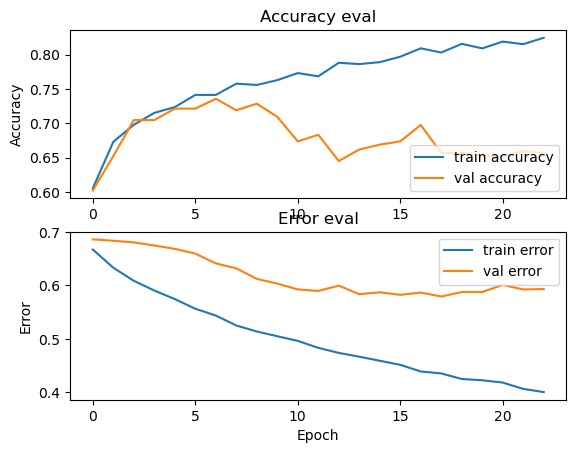

In [13]:
history = model.fit(train_dataset,
                     validation_data = validation_dataset,
                     epochs=32,
                     batch_size = 42,
                     callbacks= [early_stopping_callback]
                     )

print("Learning stoped on epoch:", early_stopping_callback.stopped_epoch)
plot_history(history)

## 📝 Evaluation

In [14]:
### here we evaluate the model using the test dataset, 
###this files have not been seen by the DL model

test_loss, test_acc = model.evaluate(test_dataset, verbose=2)
print('\nTest accuracy:', test_acc)
print('\nTest loss:', test_loss)

2/2 - 0s - loss: 0.6709 - accuracy: 0.7778 - 368ms/epoch - 184ms/step

Test accuracy: 0.7777777910232544

Test loss: 0.670920193195343


In [15]:
model.save('saved_model/his_model.h5')

In [9]:
model = tensorflow.keras.models.load_model('saved_model/his_model.h5')


2022-12-04 03:22:44.081853: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
model.evaluate(test_dataset, verbose=2)

2/2 - 1s - loss: 0.6709 - accuracy: 0.7778 - 588ms/epoch - 294ms/step


[0.670920193195343, 0.7777777910232544]

In [16]:
test_dataset.classes


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1], dtype=int32)

In [48]:
test_dataset.filenames

['Monkeypox/M04_01.jpg',
 'Monkeypox/M19_01.jpg',
 'Monkeypox/M19_02.jpg',
 'Monkeypox/M23_01.jpg',
 'Monkeypox/M38_01.jpg',
 'Monkeypox/M38_02.jpg',
 'Monkeypox/M39_01.jpg',
 'Monkeypox/M39_02.jpg',
 'Monkeypox/M40_01.jpg',
 'Monkeypox/M40_02.jpg',
 'Monkeypox/M40_03.jpg',
 'Monkeypox/M43_01.jpg',
 'Monkeypox/M43_02.jpg',
 'Monkeypox/M43_03.jpg',
 'Monkeypox/M45_01.jpg',
 'Monkeypox/M48_01.jpg',
 'Monkeypox/M48_02.jpg',
 'Monkeypox/M48_03.jpg',
 'Monkeypox/M51_01.jpg',
 'Monkeypox/M51_02.jpg',
 'Others/NM02_01.jpg',
 'Others/NM101_01.jpg',
 'Others/NM101_02.jpg',
 'Others/NM10_01.jpg',
 'Others/NM12_01.jpg',
 'Others/NM14_01.jpg',
 'Others/NM17_01.jpg',
 'Others/NM19_01.jpg',
 'Others/NM23_01.jpg',
 'Others/NM31_01.jpg',
 'Others/NM35_01.jpg',
 'Others/NM36_01.jpg',
 'Others/NM41_01.jpg',
 'Others/NM41_02.jpg',
 'Others/NM52_01.jpg',
 'Others/NM54_01.jpg',
 'Others/NM54_02.jpg',
 'Others/NM58_01.jpg',
 'Others/NM58_02.jpg',
 'Others/NM67_01.jpg',
 'Others/NM71_01.jpg',
 'Others/NM72_0

In [29]:
pred = model.predict(test_dataset)
np.round_(pred, decimals = 3)

pred = pred.flatten()

2/2 [==============================] - 0s 79ms/step


In [24]:
import pandas as pd

In [49]:
df = pd.DataFrame({'pred':pred, 'true label':test_dataset.classes})

In [58]:
df

,pred,true label
0,0.410603,0
1,0.156386,0
2,0.242949,0
3,0.746299,0
4,0.129113,0
5,0.109342,0
6,0.017154,0
7,0.208561,0
8,0.075679,0
9,0.345423,0


In [71]:
img = tf.keras.preprocessing.image.load_img('/Users/yuhou/decision analytics/samplecodes/Fold1/Fold1/Test/Monkeypox/M04_01.jpg')


In [72]:
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = img_array/255
img_array = img_array.reshape(1,224,224,3)

In [73]:
model.predict(img_array)

1/1 [==============================] - 0s 40ms/step


array([[0.41060248]], dtype=float32)

In [51]:
x=np.concatenate([test_dataset.next()[0] for i in range(test_dataset.__len__())])
y=np.concatenate([test_dataset.next()[1] for i in range(test_dataset.__len__())])
print(x.shape)
print(y.shape)

(45, 224, 224, 3)
(45,)


In [57]:
model.predict(x[0].reshape(1,224,224,3))

1/1 [==============================] - 0s 37ms/step


array([[0.4106028]], dtype=float32)

In [59]:
x[0]

array([[[0.53333336, 0.49803925, 0.43137258],
        [0.54901963, 0.5137255 , 0.454902  ],
        [0.5411765 , 0.5058824 , 0.44705886],
        ...,
        [0.6039216 , 0.45098042, 0.38431376],
        [0.5921569 , 0.4431373 , 0.36862746],
        [0.5529412 , 0.4039216 , 0.32941177]],

       [[0.49411768, 0.45882356, 0.40000004],
        [0.5176471 , 0.48235297, 0.42352945],
        [0.5254902 , 0.48627454, 0.43921572],
        ...,
        [0.5568628 , 0.40784317, 0.33333334],
        [0.56078434, 0.41176474, 0.3372549 ],
        [0.5411765 , 0.3921569 , 0.31764707]],

       [[0.45098042, 0.41960788, 0.36862746],
        [0.4666667 , 0.43529415, 0.38431376],
        [0.47450984, 0.4431373 , 0.40000004],
        ...,
        [0.5176471 , 0.36862746, 0.29411766],
        [0.52156866, 0.37254903, 0.29803923],
        [0.5137255 , 0.3647059 , 0.2901961 ]],

       ...,

       [[0.7294118 , 0.6039216 , 0.5529412 ],
        [0.7372549 , 0.6117647 , 0.56078434],
        [0.7411765 , 0

In [80]:
pred = model.predict(img_array)

1/1 [==============================] - 0s 26ms/step


In [83]:
pred[0][0]

0.41060248

In [91]:
class_dict = test_dataset.class_indices

In [ ]:
def classify(score, threshold):
    if score >= threshold:
        result = 1
    if score < threshold:
        result = return 0
    return list(class_dict.keys())[list(class_dict.values()).index(result)]

In [88]:
mydict = {'george': 16, 'amber': 19}
print(list(mydict.keys())[list(mydict.values()).index(16)])  # P

george


In [90]:
list(mydict.values()).index(16)

0

'Monkeypox'